#### Setup & Imports

In [ ]:
!pip install fvcore

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import gc
from typing import List

from collections import defaultdict, Counter

# from thop import profile
from fvcore.nn import FlopCountAnalysis, parameter_count


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

SUBSET_SIZE = 700
EPOCHS = 20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=3f996865666e4e9ba0d369b81639eb37ddedafedd7c35ca7ab9a71a81895a0d7
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=063f8eebff99f07627b07104233fb0c64970aae1cd17400f13abca9b7b5cd64d
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath
Device: cuda
GPU Memory: 15.83 GB


In [ ]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(seed=42)

# Force garbage collection
def cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def prune_architecture(model, keep_edges=2):
    print(f"\n🔧 Pruning architecture (keeping top-{keep_edges} edges per node)...")

    arch_before = model.discretize_architecture()
    print("Architecture BEFORE pruning:")
    for cell_name, ops in arch_before.items():
        print(f"  {cell_name}: {ops}")

    alpha_normal = model.alpha_normal.detach()
    alpha_reduce = model.alpha_reduce.detach()

    # Prune each cell
    for i, cell_type in enumerate(model.cell_types):
        if cell_type == 'normal':
            alpha = alpha_normal[i]
        else:
            alpha = alpha_reduce[i]

        num_nodes = 2  # We have 2 intermediate nodes
        pruned_alpha = alpha.clone()

        for node_idx in range(num_nodes):
            edge_start = node_idx * 2
            edge_end = edge_start + 2

            # Get scores for edges connecting to this node
            edge_scores = torch.max(alpha[edge_start:edge_end], dim=1)[0]

            # Keep only top-k edges
            _, keep_indices = torch.topk(edge_scores, keep_edges)

            mask = torch.ones_like(alpha[edge_start:edge_end])
            for edge_idx in range(2):
                if edge_idx not in keep_indices:
                    mask[edge_idx] = 0
                    pruned_alpha[edge_start + edge_idx] = -1e9  # Very low score

            # Update architecture parameters
            if cell_type == 'normal':
                model.alpha_normal.data[i][edge_start:edge_end] = pruned_alpha[edge_start:edge_end]
            else:
                model.alpha_reduce.data[i][edge_start:edge_end] = pruned_alpha[edge_start:edge_end]

    arch_after = model.discretize_architecture()
    print("Architecture AFTER pruning:")
    for cell_name, ops in arch_after.items():
        print(f"  {cell_name}: {ops}")

    return model

def get_pruned_architecture_ops(model):
    arch = {}
    alpha_normal = F.softmax(model.alpha_normal, dim=-1)
    alpha_reduce = F.softmax(model.alpha_reduce, dim=-1)

    for i, cell_type in enumerate(model.cell_types):
        if cell_type == 'normal':
            alpha = alpha_normal[i]
        else:
            alpha = alpha_reduce[i]

        final_ops = []
        for edge_idx in range(model.num_edges):  # Always 4 edges
            op_idx = torch.argmax(alpha[edge_idx]).item()
            op_name = list(TINY_OPS.keys())[op_idx]
            final_ops.append(op_name)

        arch[f'cell_{i}_{cell_type}'] = final_ops

    return arch


# =====================
# SUPERVISED FINE-TUNING (ULTRA-LIGHT)
# =====================
def get_supervised_data(fraction=0.1, batch_size=32):
    """Get limited labeled data"""
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.491, 0.482, 0.447], [0.202, 0.199, 0.201])
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    # Limit training data
    if fraction < 1.0:
        n_samples = int(len(trainset) * fraction)
        indices = torch.randperm(len(trainset))[:n_samples].tolist()
        trainset = torch.utils.data.Subset(trainset, indices)
        print(f"Using {len(trainset)} training samples ({fraction*100:.1f}%)")

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    return train_loader, test_loader

#### Helpers

In [ ]:
from fvcore.nn import FlopCountAnalysis, parameter_count

def count_flops(model, input_size=(1, 3, 32, 32), verbose=False, count_arch_params=False):
    try:
        device = next(model.parameters()).device
        reference_input = torch.randn(input_size).to(device)

        # Put model in eval mode
        was_training = model.training
        model.eval()

        # Get FLOPs count from fvcore - this includes ALL operations
        flops_analyzer = FlopCountAnalysis(model, reference_input)
        total_flops = flops_analyzer.total()

        # Count parameters
        if count_arch_params:
            total_params = sum(p.numel() for p in model.parameters())
        else:
            # Exclude architecture parameters (alpha_normal, alpha_reduce)
            total_params = sum(p.numel() for n, p in model.named_parameters()
                             if 'alpha' not in n)

        # Restore training mode if needed
        if was_training:
            model.train()

        flops_m, params_m = total_flops / 1e6, total_params / 1e6

        if verbose:
            print(f"📊 Model Statistics:")
            print(f"   Parameters: {params_m:.2f}M ({total_params:,} total)")
            print(f"   Total FLOPs: {flops_m:.2f}M ({total_flops:,} total)")

            # Show breakdown
            print(f"\n   Operations breakdown (top 5):")
            flops_by_op = flops_analyzer.by_module()
            sorted_ops = sorted(flops_by_op.items(), key=lambda x: x[1], reverse=True)
            for op_name, op_flops in sorted_ops[:5]:
                if op_flops > 0:
                    print(f"     {op_name}: {op_flops/1e6:.2f}M FLOPs")

        # Check constraints
        if verbose:
            target_params = 1e6
            target_flops = 100e6
            meets_params = total_params < target_params
            meets_flops = total_flops < target_flops

            print(f"\n📏 CONSTRAINT CHECK:")
            print(f"   Parameters: {params_m:.2f}M / {target_params/1e6:.1f}M - "
                  f"{'✅' if meets_params else '❌'}")
            print(f"   FLOPs: {flops_m:.2f}M / {target_flops/1e6:.0f}M - "
                  f"{'✅' if meets_flops else '❌'}")

            if meets_params and meets_flops:
                print("   🎉 ALL CONSTRAINTS MET!")
            else:
                print("   ⚠️  SOME CONSTRAINTS VIOLATED")
                if not meets_params:
                    print(f"      Parameters exceed by: {params_m - 1.0:.2f}M")
                if not meets_flops:
                    print(f"      FLOPs exceed by: {flops_m - 100:.2f}M")

        return total_flops, total_params

    except Exception as e:
        print(f"⚠️  FLOP counting failed: {e}")
        import traceback
        traceback.print_exc()

        # Fallback
        if count_arch_params:
            params = sum(p.numel() for p in model.parameters())
        else:
            params = sum(p.numel() for n, p in model.named_parameters()
                        if 'alpha' not in n)
        return 0, params

def check_constraints(self, input_size=(1, 3, 32, 32)):
    weight_params = self.count_parameters()
    flops, _ = count_flops(self, input_size)  # Now uses fvcore

    meets_params = weight_params < 1e6  # < 1M
    meets_flops = flops < 100e6  # < 100M

    print(f"📊 Constraint Check (fvcore):")
    print(f"   Parameters: {weight_params/1e6:.2f}M / 1.0M - {'✓' if meets_params else '❌'}")
    print(f"   FLOPs: {flops/1e6:.2f}M / 100M - {'✓' if meets_flops else '❌'}")

    return meets_params and meets_flops

def get_model_stats(model, input_size=(1, 3, 32, 32), count_arch_params=False):
    try:
        flops, params = count_flops(model, input_size, verbose=False,
                                   count_arch_params=count_arch_params)

        memory_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 ** 2)

        return {
            'parameters': params,
            'parameters_m': params / 1e6,
            'flops': flops,
            'flops_m': flops / 1e6,
            'memory_mb': memory_mb
        }
    except Exception as e:
        print(f"⚠️  Model stats failed: {e}")
        params = sum(p.numel() for p in model.parameters())
        return {
            'parameters': params,
            'parameters_m': params / 1e6,
            'flops': 0,
            'flops_m': 0,
            'memory_mb': 0
        }

def check_model_constraints(model, verbose=True, count_arch_params=False):
    stats = get_model_stats(model, count_arch_params=count_arch_params)

    meets_params = stats['parameters'] < 1e6
    meets_flops = stats['flops'] < 100e6

    if verbose:
        model_name = model.__class__.__name__
        if hasattr(model, 'name'):
            model_name = model.name

        print(f"\n📏 CONSTRAINT CHECK for {model_name}:")
        print(f"   Parameters: {stats['parameters_m']:.2f}M / 1.0M - "
              f"{'✅' if meets_params else '❌'}")
        print(f"   FLOPs: {stats['flops_m']:.2f}M / 100M - "
              f"{'✅' if meets_flops else '❌'}")
        if meets_params and meets_flops:
            print("   🎉 ALL CONSTRAINTS MET!")
        else:
            print("   ⚠️  SOME CONSTRAINTS VIOLATED")
            if not meets_params:
                print(f"      Parameters exceed by: {stats['parameters_m'] - 1.0:.2f}M")
            if not meets_flops:
                print(f"      FLOPs exceed by: {stats['flops_m'] - 100:.2f}M")

    return {
        'meets_constraints': meets_params and meets_flops,
        'meets_params': meets_params,
        'meets_flops': meets_flops,
        **stats
    }


def evaluate_model_flops_consistently(model, model_name, is_search_model=False):
    print(f"\n{'='*60}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*60}")

    # For search models, count all parameters including arch params
    count_arch = True if is_search_model else False

    # Get stats
    stats = get_model_stats(model, count_arch_params=count_arch)

    print(f"📊 Statistics:")
    print(f"   Parameters: {stats['parameters_m']:.2f}M")
    print(f"   FLOPs: {stats['flops_m']:.2f}M")
    print(f"   Memory: {stats['memory_mb']:.1f}MB")

    # Check constraints (search models have different constraints)
    if not is_search_model:
        constraint_result = check_model_constraints(model, verbose=True,
                                                   count_arch_params=count_arch)
        stats.update(constraint_result)

    return stats

### Auto-SSL Architecture


[0/3] Model Creation & Analysis
Cell 0 (normal): input=8 -> output=8 -> final=16
Cell 1 (reduction): input=16 -> output=8 -> final=16
Cell 2 (normal): input=16 -> output=16 -> final=32
Architecture: 3 cells, final channels: 32

MODEL ANALYSIS
Weight parameters: 97,848 (0.10M)
Arch parameters: 216 (0.0002M)
Total parameters: 98,064 (0.10M)


cells.0._ops.0._ops.7, cells.0._ops.1._ops.7, cells.0._ops.2._ops.7, cells.0._ops.3._ops.7, cells.1._ops.0._ops.7, cells.1._ops.1._ops.7, cells.1._ops.2._ops.7, cells.1._ops.3._ops.7, cells.2._ops.0._ops.7, cells.2._ops.1._ops.7, cells.2._ops.2._ops.7, cells.2._ops.3._ops.7



[1/3] DARTS Architecture Search with Bilevel Optimization
DARTS-style AutoSSL-Tiny (PROPER BILEVEL OPTIMIZATION)
Epochs: 20
Cell 0 (normal): input=8 -> output=8 -> final=16
Cell 1 (reduction): input=16 -> output=8 -> final=16
Cell 2 (normal): input=16 -> output=16 -> final=32
Architecture: 3 cells, final channels: 32
✓ Model created: 97,848 weight parameters
✓ Architecture parameters: 216

✓ Loading data...


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


✓ Train batches: 50
✓ Val batches: 13


/tmp/ipython-input-3176866883.py:504: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
/tmp/ipython-input-3176866883.py:521: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-3176866883.py:564: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch  1/20: Train SSL=0.4799, Val SSL=0.4536
Epoch  2/20: Train SSL=0.5063, Val SSL=0.4775
  Architecture snapshot:
    cell_0_normal: ['irb_e3', 'zero', 'identity', 'ds_conv_se']
Epoch  3/20: Train SSL=0.4833, Val SSL=0.5605
Epoch  4/20: Train SSL=0.4537, Val SSL=0.4341
  Architecture snapshot:
    cell_0_normal: ['irb_e3', 'zero', 'identity', 'ds_conv_se']
Epoch  5/20: Train SSL=0.4317, Val SSL=0.4126
Epoch  6/20: Train SSL=0.4143, Val SSL=0.4217
  Architecture snapshot:
    cell_0_normal: ['irb_e3', 'zero', 'identity', 'identity']
Epoch  7/20: Train SSL=0.3517, Val SSL=0.3736
Epoch  8/20: Train SSL=0.3606, Val SSL=0.2859
  Architecture snapshot:
    cell_0_normal: ['ds_conv_se', 'zero', 'identity', 'identity']
Epoch  9/20: Train SSL=0.3170, Val SSL=0.2851
Epoch 10/20: Train SSL=0.2975, Val SSL=0.3039
  Architecture snapshot:
    cell_0_normal: ['irb_e3_se', 'zero', 'identity', 'identity']
Epoch 11/20: Train SSL=0.3712, Val SSL=0.3027
Epoch 12/20: Train SSL=0.3076, Val SSL=0.3245
  

cells.0._ops.0._ops.7, cells.0._ops.1._ops.7, cells.0._ops.2._ops.7, cells.0._ops.3._ops.7, cells.1._ops.0._ops.7, cells.1._ops.1._ops.7, cells.1._ops.2._ops.7, cells.1._ops.3._ops.7, cells.2._ops.0._ops.7, cells.2._ops.1._ops.7, cells.2._ops.2._ops.7, cells.2._ops.3._ops.7



🔧 Pruning architecture (keeping top-2 edges per node)...
Architecture BEFORE pruning:
  cell_0_normal: ['irb_e6_se', 'identity', 'irb_e6_se', 'irb_e3_se']
  cell_1_reduction: ['identity', 'ds_conv_se', 'irb_e3', 'ds_conv']
  cell_2_normal: ['zero', 'ds_conv', 'irb_e3_se', 'identity']
Architecture AFTER pruning:
  cell_0_normal: ['irb_e6_se', 'identity', 'irb_e6_se', 'irb_e3_se']
  cell_1_reduction: ['identity', 'ds_conv_se', 'irb_e3', 'ds_conv']
  cell_2_normal: ['zero', 'ds_conv', 'irb_e3_se', 'identity']

✓ Final pruned architecture:
  cell_0_normal: ['irb_e6_se', 'identity', 'irb_e6_se', 'irb_e3_se']
  cell_1_reduction: ['identity', 'ds_conv_se', 'irb_e3', 'ds_conv']
  cell_2_normal: ['zero', 'ds_conv', 'irb_e3_se', 'identity']
✓ Model parameters after pruning: 97,848


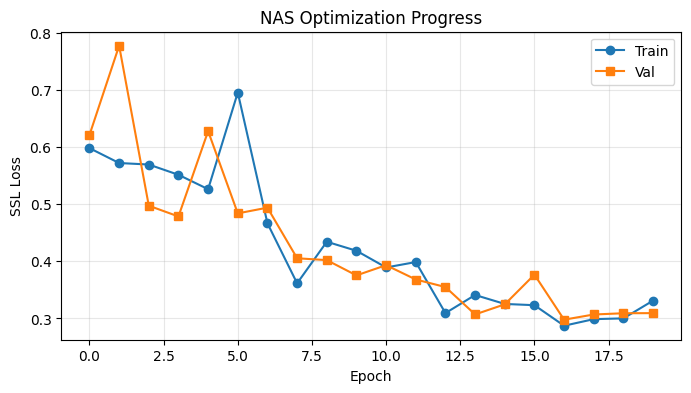


✓ Architecture search with pruning completed successfully!

🎯 Search completed! Final architecture has 3 cells


In [ ]:
class SqueezeExcite(nn.Module):
    """Lightweight Squeeze-and-Excitation module"""
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.channels = channels
        self.reduction = reduction

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Get batch size and channels
        b, c, _, _ = x.size()

        # Squeeze: global average pooling
        y = self.gap(x).view(b, c)

        # Excite: attention weights
        y = self.attention(y).view(b, c, 1, 1)

        # Scale input features
        return x * y.expand_as(x)

class MixedOp(nn.Module):
    """Fixed mixed operation with proper dimension handling"""
    def __init__(self, C_in, C_out, op_names):
        super().__init__()
        self._ops = nn.ModuleList()
        self._adjustments = nn.ModuleDict()  # Store channel adjustment convs
        self.C_out = C_out

        for op_name in op_names:
            op = TINY_OPS[op_name]
            op_module = op(C_in, C_out)
            self._ops.append(op_module)

            # Pre-create and register adjustment convs if needed
            # We need to check what output channels each op produces
            if not hasattr(op_module, 'C_out'):
                # Create test input to determine output channels
                test_input = torch.randn(1, C_in, 32, 32)
                with torch.no_grad():
                    test_output = op_module(test_input)
                op_output_channels = test_output.shape[1]
            else:
                op_output_channels = op_module.C_out

            if op_output_channels != C_out:
                adj_key = f"adj_{op_name}_{op_output_channels}_{C_out}"
                self._adjustments[adj_key] = nn.Conv2d(op_output_channels, C_out, 1)

    def forward(self, x, weights):
        """Weighted sum of all operations"""
        results = []
        for w, op in zip(weights, self._ops):
            result = op(x)

            # Apply channel adjustment if needed
            if result.shape[1] != self.C_out:
                # Find the right adjustment
                op_name = type(op).__name__
                adj_key = f"adj_{op_name}_{result.shape[1]}_{self.C_out}"
                if adj_key in self._adjustments:
                    result = self._adjustments[adj_key](result)

            results.append(w * result)
        return sum(results)

class Cell(nn.Module):
    """Simplified but robust DARTS-style cell"""
    def __init__(self, C_prev, C, op_names, reduction=False):
        super().__init__()
        self.C_in = C_prev
        self.C_out = C
        self.reduction = reduction

        # FIXED: Proper preprocessing for both inputs
        self.preprocess0 = nn.Sequential(
            nn.Conv2d(C_prev, C, 1, bias=False),
            nn.BatchNorm2d(C)
        ) if C_prev != C else nn.Identity()

        self.preprocess1 = nn.Sequential(
            nn.Conv2d(C_prev, C, 1, bias=False),
            nn.BatchNorm2d(C)
        ) if C_prev != C else nn.Identity()

        # Operations for 2 intermediate nodes, each with 2 inputs
        self.num_edges = 4  # 2 nodes × 2 inputs each
        self._ops = nn.ModuleList()
        for _ in range(self.num_edges):
            op = MixedOp(C, C, op_names)  # All operations output C channels
            self._ops.append(op)

    def forward(self, s0, weights):
        """Forward through cell with architecture weights"""
        s0_0 = self.preprocess0(s0)
        s0_1 = self.preprocess1(s0)

        states = [s0_0, s0_1]
        new_states = []

        # First intermediate node: connects to both inputs
        node0_input = sum(self._ops[i](states[i], weights[i]) for i in range(2))
        new_states.append(F.relu(node0_input))

        # Second intermediate node: connects to both inputs
        node1_input = sum(self._ops[i+2](states[i], weights[i+2]) for i in range(2))
        new_states.append(F.relu(node1_input))

        # Output is concatenation of intermediate nodes
        return torch.cat(new_states, dim=1)


class TinyDSConv(nn.Module):
    """Depthwise separable conv with proper channel handling"""
    def __init__(self, C_in, C_out, use_se=False):
        super().__init__()
        self.use_se = use_se

        # Depthwise conv: input channels = output channels = C_in
        self.depthwise = nn.Conv2d(C_in, C_in, 3, 1, 1, groups=C_in, bias=False)
        self.bn_depthwise = nn.BatchNorm2d(C_in)

        # Pointwise conv: convert from C_in to C_out
        self.pointwise = nn.Conv2d(C_in, C_out, 1, bias=False)
        self.bn_pointwise = nn.BatchNorm2d(C_out)

        self.relu = nn.ReLU(inplace=True)

        # Add SE module if requested
        if use_se:
            self.se = SqueezeExcite(C_out)
        else:
            self.se = nn.Identity()

    def forward(self, x):
        # Depthwise convolution
        x = self.depthwise(x)
        x = self.bn_depthwise(x)
        x = self.relu(x)

        # Pointwise convolution
        x = self.pointwise(x)
        x = self.bn_pointwise(x)
        x = self.relu(x)

        # Squeeze-and-excitation
        x = self.se(x)
        return x

class TinyIRB(nn.Module):
    """Inverted residual block with optional SE - FIXED VERSION"""
    def __init__(self, C_in, C_out, expand=3, use_se=False):
        super().__init__()
        hidden = C_in * expand
        self.use_res = (C_in == C_out)

        # FIXED: Handle residual connection properly
        if C_in != C_out:
            self.res_conv = nn.Sequential(
                nn.Conv2d(C_in, C_out, 1, bias=False),
                nn.BatchNorm2d(C_out)
            )
        else:
            self.res_conv = nn.Identity()

        self.conv = nn.Sequential(
            nn.Conv2d(C_in, hidden, 1, bias=False),
            nn.BatchNorm2d(hidden),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden, hidden, 3, 1, 1, groups=hidden, bias=False),
            nn.BatchNorm2d(hidden),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden, C_out, 1, bias=False),
            nn.BatchNorm2d(C_out)
        )

        # Add SE module if requested
        if use_se:
            self.se = SqueezeExcite(C_out)
        else:
            self.se = nn.Identity()

    def forward(self, x):
        out = self.conv(x)
        out = self.se(out)
        if self.use_res:
            out = out + x
        else:
            out = out + self.res_conv(x)  # Channel adjustment for residual
        return out


class TinySE(nn.Module):
    """Standalone Squeeze-and-Excitation operation"""
    def __init__(self, C_in, C_out, reduction=4):
        super().__init__()
        if C_in != C_out:
            self.channel_adjust = nn.Conv2d(C_in, C_out, 1, bias=False)
        else:
            self.channel_adjust = nn.Identity()

        self.se = SqueezeExcite(C_out, reduction)

    def forward(self, x):
        x = self.channel_adjust(x)
        return self.se(x)


class TinyIdentity(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()
        self.C_in = C_in
        self.C_out = C_out

        # Only need channel adjustment if input and output channels differ
        if C_in != C_out:
            self.channel_adjust = nn.Sequential(
                nn.Conv2d(C_in, C_out, 1, bias=False),
                nn.BatchNorm2d(C_out)
            )
        else:
            self.channel_adjust = nn.Identity()

    def forward(self, x):
        return self.channel_adjust(x)

# Add a zero operation for proper DARTS
class TinyZero(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()
        self.C_in = C_in
        self.C_out = C_out

    def forward(self, x):
        if self.C_in == self.C_out:
            return x * 0.0  # Zero operation
        else:
            return torch.zeros(x.size(0), self.C_out, x.size(2), x.size(3)).to(x.device)

# Updated operation set with SE variants
TINY_OPS = {
    'ds_conv': lambda c_in, c_out: TinyDSConv(c_in, c_out, use_se=False),
    'ds_conv_se': lambda c_in, c_out: TinyDSConv(c_in, c_out, use_se=True),
    'irb_e3': lambda c_in, c_out: TinyIRB(c_in, c_out, 3, use_se=False),
    'irb_e3_se': lambda c_in, c_out: TinyIRB(c_in, c_out, 3, use_se=True),
    'irb_e6': lambda c_in, c_out: TinyIRB(c_in, c_out, 6, use_se=False),
    'irb_e6_se': lambda c_in, c_out: TinyIRB(c_in, c_out, 6, use_se=True),
    'se': TinySE,  # Standalone SE operation
    'identity': TinyIdentity,
    'zero': TinyZero,
}

# ==========================================
# ULTRA-LIGHTWEIGHT MODEL
# ==========================================
class DARTSAutoSSL(nn.Module):
    def __init__(self, C=5, num_cells=4):  # Reduced from C=8 to C=5 for FLOPS
        super().__init__()
        self.C = C
        self.num_cells = num_cells

        # Stem convolution - make it lighter
        self.stem = nn.Sequential(
            nn.Conv2d(3, C, 3, 1, 1, bias=False),
            nn.BatchNorm2d(C),
            nn.ReLU(inplace=True)
        )

        # Cell configurations - MORE CONSERVATIVE CHANNEL PROGRESSION
        self.cells = nn.ModuleList()
        self.cell_types = []

        # Track current channels
        current_C = C

        for i in range(num_cells):
            # Only one reduction cell, placed earlier to reduce computation
            if i == 1:  # Reduction cell at position 1 (earlier)
                cell_type = 'reduction'
                cell_C_out = min(current_C * 1, 8)  # Reduced growth: only 1x, cap at 8
            else:
                cell_type = 'normal'
                cell_C_out = current_C

            cell = Cell(current_C, cell_C_out, list(TINY_OPS.keys()), reduction=(cell_type=='reduction'))
            self.cells.append(cell)
            self.cell_types.append(cell_type)

            # FIXED: Each cell outputs cell_C_out * 2 due to concatenation
            current_C = cell_C_out * 2

            print(f"Cell {i} ({cell_type}): input={cell.C_in} -> output={cell.C_out} -> final={current_C}")

        # Architecture parameters
        self.num_edges = 4
        num_ops = len(TINY_OPS)

        self.alpha_normal = nn.Parameter(
            1e-3 * torch.randn(num_cells, self.num_edges, num_ops)
        )
        self.alpha_reduce = nn.Parameter(
            1e-3 * torch.randn(num_cells, self.num_edges, num_ops)
        )

        # Global pooling and projection for SSL - REDUCED PROJECTION
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        # Final channels: current_C (already accounts for concatenation)
        self.proj = nn.Sequential(
            nn.Linear(current_C, 32),  # Reduced from 64 to 32
            nn.ReLU(inplace=True),
            nn.Linear(32, 16)          # Reduced from 32 to 16
        )

        print(f"Architecture: {num_cells} cells, final channels: {current_C}")

    def forward(self, x):
        x = self.stem(x)

        for i, cell in enumerate(self.cells):
            # Get architecture weights for this cell
            if self.cell_types[i] == 'normal':
                alpha = self.alpha_normal[i]
            else:
                alpha = self.alpha_reduce[i]

            # Softmax over operations for each edge
            weights = F.softmax(alpha, dim=-1)

            x = cell(x, weights)

        x = self.global_pool(x).flatten(1)
        return self.proj(x)

    def expand_channels(self, width_multiplier=1.0):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.BatchNorm2d, nn.Linear)):
                pass  # Will need to implement channel scaling logic

    def get_arch_parameters(self):
        return [self.alpha_normal, self.alpha_reduce]

    def get_weight_parameters(self):
        return [p for n, p in self.named_parameters() if 'alpha' not in n]

    def discretize_architecture(self):
        """Convert continuous architecture to discrete"""
        arch = {}
        for i, cell_type in enumerate(self.cell_types):
            if cell_type == 'normal':
                alpha = self.alpha_normal[i]
            else:
                alpha = self.alpha_reduce[i]

            edge_ops = []
            for edge_idx in range(self.num_edges):
                op_idx = torch.argmax(alpha[edge_idx]).item()
                op_name = list(TINY_OPS.keys())[op_idx]
                edge_ops.append(op_name)

            arch[f'cell_{i}_{cell_type}'] = edge_ops

        return arch

    def count_parameters(self):
        """Count parameters excluding architecture parameters"""
        return sum(p.numel() for p in self.get_weight_parameters())

    def analyze_model(self, input_size=(1, 3, 32, 32)):
        print("\n" + "="*50)
        print("MODEL ANALYSIS")
        print("="*50)

        # Count parameters
        weight_params = self.count_parameters()
        arch_params = sum(p.numel() for p in self.get_arch_parameters())
        total_params = weight_params + arch_params

        print(f"Weight parameters: {weight_params:,} ({weight_params/1e6:.2f}M)")
        print(f"Arch parameters: {arch_params:,} ({arch_params/1e6:.4f}M)")
        print(f"Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")

        # Count FLOPs
        flops, _ = count_flops(self, input_size)

        return weight_params, flops

# ==========================================
# MEMORY-EFFICIENT DATA LOADING
# ==========================================
class TinySSLTransform:
    """Lightweight augmentation"""
    def __call__(self, x):
        # Simple augmentations
        x = transforms.functional.to_tensor(x)
        if torch.rand(1) > 0.5:
            x = transforms.functional.hflip(x)
        if torch.rand(1) > 0.5:
            x = transforms.functional.adjust_brightness(x, 1 + 0.2 * (torch.rand(1) - 0.5))
        x = transforms.functional.normalize(x, [0.5]*3, [0.5]*3)
        return x

def get_tiny_dataloaders(subset_size=SUBSET_SIZE, batch_size=32):
    transform = TinySSLTransform()

    full_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=None
    )

    indices = torch.randperm(len(full_dataset))[:subset_size].tolist()

    class SubsetWithTransform(torch.utils.data.Dataset):
        def __init__(self, dataset, indices, transform):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            img, _ = self.dataset[self.indices[idx]]
            return self.transform(img), self.transform(img)

    subset = SubsetWithTransform(full_dataset, indices, transform)

    train_size = int(0.8 * len(subset))
    val_size = len(subset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        subset, [train_size, val_size]
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=False
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=False
    )

    return train_loader, val_loader

# ==========================================
# SIMPLE BARLOW TWINS
# ==========================================
class SimpleBarlowTwins(nn.Module):
    def __init__(self, lam=0.005):
        super().__init__()
        self.lam = lam

    def forward(self, z1, z2):
        # Normalize
        z1 = (z1 - z1.mean(0)) / (z1.std(0) + 1e-8)
        z2 = (z2 - z2.mean(0)) / (z2.std(0) + 1e-8)

        # Cross-correlation
        N = z1.size(0)
        c = (z1.T @ z2) / N

        # Loss
        on_diag = ((torch.diag(c) - 1) ** 2).sum()
        off_diag = ((c - torch.diag(torch.diag(c))) ** 2).sum()

        return on_diag + self.lam * off_diag

# ==========================================
# GRADIENT ACCUMULATION TRAINING
# ==========================================
def train_darts_ssl(epochs=20, accum_steps=4):
    print("="*70)
    print("DARTS-style AutoSSL-Tiny (PROPER BILEVEL OPTIMIZATION)")
    print(f"Epochs: {epochs}")
    print("="*70)

    model = DARTSAutoSSL(C=8, num_cells=3).to(device)
    total_params = model.count_parameters()
    arch_params = sum(p.numel() for p in model.get_arch_parameters())

    print(f"✓ Model created: {total_params:,} weight parameters")
    print(f"✓ Architecture parameters: {arch_params:,}")

    w_opt = optim.Adam(model.get_weight_parameters(), lr=1e-3, weight_decay=1e-4)
    alpha_opt = optim.Adam(model.get_arch_parameters(), lr=3e-4, weight_decay=1e-3)

    criterion = SimpleBarlowTwins()

    # Data
    print("\n✓ Loading data...")
    train_loader, val_loader = get_tiny_dataloaders(subset_size=1000, batch_size=16)
    print(f"✓ Train batches: {len(train_loader)}")
    print(f"✓ Val batches: {len(val_loader)}")

    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # ========== PHASE 1: Update Weights (w) on TRAIN data ==========
        model.train()
        epoch_loss = 0
        w_opt.zero_grad()

        for batch_idx, (x1, x2) in enumerate(train_loader):
            if batch_idx >= 2:  # Only process 2 batches for testing
                break

            x1, x2 = x1.to(device), x2.to(device)

            if use_amp:
                with torch.cuda.amp.autocast():
                    z1, z2 = model(x1), model(x2)
                    loss = criterion(z1, z2) / accum_steps
                scaler.scale(loss).backward()
            else:
                z1, z2 = model(x1), model(x2)
                loss = criterion(z1, z2) / accum_steps
                loss.backward()

            epoch_loss += loss.item() * accum_steps

            # Gradient accumulation
            if (batch_idx + 1) % accum_steps == 0:
                if use_amp:
                    scaler.step(w_opt)
                    scaler.update()
                else:
                    w_opt.step()
                w_opt.zero_grad()

            del x1, x2, z1, z2, loss

        if len(train_loader) > 0:
            avg_train = epoch_loss / min(len(train_loader), 2)
        else:
            avg_train = epoch_loss
        history['train_loss'].append(avg_train)
        cleanup()

        # ========== PHASE 2: Update Architecture (α) on VALIDATION data ==========
        model.train()
        val_loss = 0
        alpha_opt.zero_grad()

        w_current = {n: p.detach().clone() for n, p in model.named_parameters() if 'alpha' not in n}

        for batch_idx, (x1, x2) in enumerate(val_loader):
            if batch_idx >= 2:
                break

            x1, x2 = x1.to(device), x2.to(device)

            if use_amp:
                with torch.cuda.amp.autocast():
                    z1, z2 = model(x1), model(x2)
                    loss = criterion(z1, z2)
                scaler.scale(loss).backward()
            else:
                z1, z2 = model(x1), model(x2)
                loss = criterion(z1, z2)
                loss.backward()

            val_loss += loss.item()
            del x1, x2, z1, z2, loss

        if len(val_loader) > 0:
            avg_val = val_loss / min(len(val_loader), 2)
        else:
            avg_val = val_loss
        history['val_loss'].append(avg_val)

        if use_amp:
            scaler.step(alpha_opt)
            scaler.update()
        else:
            alpha_opt.step()
        alpha_opt.zero_grad()

        with torch.no_grad():
            for n, p in model.named_parameters():
                if 'alpha' not in n and n in w_current:
                    p.copy_(w_current[n])

        cleanup()

        print(f"Epoch {epoch+1:2d}/{epochs}: Train SSL={avg_train:.4f}, Val SSL={avg_val:.4f}")

        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            arch = model.discretize_architecture()
            print(f"  Architecture snapshot:")
            for cell_name, ops in list(arch.items())[:1]:  # Show first cell only
                print(f"    {cell_name}: {ops}")

    print("\n✓ SSL-guided architecture search complete!")

    arch = model.discretize_architecture()
    print("\nFinal Discovered Architecture:")
    for cell_name, ops in arch.items():
        print(f"  {cell_name}: {ops}")

    return model, history

class TinyClassifier(nn.Module):
    """Tiny classifier using discovered architecture"""
    def __init__(self, ssl_model, num_classes=10):
        super().__init__()
        self.C = ssl_model.C
        self.stem = ssl_model.stem

        arch = ssl_model.get_arch()
        self.cells = nn.ModuleList()
        for op_name in arch:
            op_fn = TINY_OPS[op_name]
            self.cells.append(op_fn(self.C, self.C))

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.C, num_classes)

    def forward(self, x):
        x = self.stem(x)
        for cell in self.cells:
            x = cell(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

def finetune_classifier(ssl_model, data_fraction=0.1, epochs=EPOCHS):
    """Lightweight fine-tuning"""
    print("\n" + "="*70)
    print(f"Fine-tuning on {data_fraction*100}% labeled data ({epochs} epochs)")
    print("="*70)

    # Build classifier
    classifier = TinyClassifier(ssl_model, num_classes=10).to(device)
    print(f"✓ Classifier: {sum(p.numel() for p in classifier.parameters()):,} params")

    # Data
    train_loader, test_loader = get_supervised_data(data_fraction, batch_size=32)

    # Training
    optimizer = optim.SGD(classifier.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    for epoch in range(epochs):
        classifier.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = classifier(inputs)
                    loss = criterion(outputs, targets)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = classifier(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            del inputs, targets, outputs, loss

        scheduler.step()
        cleanup()

        # Evaluate
        classifier.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = classifier(inputs)
                _, pred = outputs.max(1)
                total += targets.size(0)
                correct += pred.eq(targets).sum().item()
                del inputs, targets, outputs, pred

        acc = 100.0 * correct / total
        best_acc = max(best_acc, acc)

        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1:2d}/{epochs}: Acc={acc:.2f}% (Best={best_acc:.2f}%)")

        cleanup()

    return classifier, best_acc


# =====================
# MAIN EXECUTION
def main():
    try:
        print("\n" + "="*70)
        print("[0/3] Model Creation & Analysis")
        print("="*70)
        model = DARTSAutoSSL(C=8, num_cells=3).to(device)
        weight_params, flops = model.analyze_model(input_size=(1, 3, 32, 32))

        # Step 1: Architecture search with bilevel optimization
        print("\n" + "="*70)
        print("[1/3] DARTS Architecture Search with Bilevel Optimization")
        print("="*70)
        ssl_model, history = train_darts_ssl(epochs=20, accum_steps=2)
        ssl_model, history = train_darts_ssl(epochs=20, accum_steps=2)

        # NEW: Also analyze after architecture search
        if ssl_model is not None:
            print("\n" + "="*70)
            print("[ANALYSIS] After Architecture Search")
            print("="*70)
            ssl_model.analyze_model(input_size=(1, 3, 32, 32))
            ssl_model = prune_architecture(ssl_model, keep_edges=2)

            # Get final architecture after pruning
            final_arch = get_pruned_architecture_ops(ssl_model)
            print(f"\n✓ Final pruned architecture:")
            for cell_name, ops in final_arch.items():
                print(f"  {cell_name}: {ops}")

            # Count parameters after pruning
            total_params = ssl_model.count_parameters()
            print(f"✓ Model parameters after pruning: {total_params:,}")

            # Simple plot
            plt.figure(figsize=(8, 4))
            plt.plot(history['train_loss'], label='Train', marker='o')
            plt.plot(history['val_loss'], label='Val', marker='s')
            plt.xlabel('Epoch')
            plt.ylabel('SSL Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.title('NAS Optimization Progress')
            plt.show()

            print("\n✓ Architecture search with pruning completed successfully!")
            return ssl_model, history, final_arch
        else:
            print("\n✗ Architecture search failed")
            return None, None, None

    except Exception as e:
        print(f"\n✗ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    ssl_model, history, final_arch = main()

    # Optional: Show what we got
    if ssl_model is not None:
        print(f"\n🎯 Search completed! Final architecture has {len(final_arch)} cells")

### Experiments

AutoSSL-Tiny: Evaluation Framework

[1/4] Running Architecture Search...

[0/3] Model Creation & Analysis
Cell 0 (normal): input=8 -> output=8 -> final=16
Cell 1 (reduction): input=16 -> output=8 -> final=16
Cell 2 (normal): input=16 -> output=16 -> final=32
Architecture: 3 cells, final channels: 32

MODEL ANALYSIS
Weight parameters: 97,848 (0.10M)
Arch parameters: 216 (0.0002M)
Total parameters: 98,064 (0.10M)


cells.0._ops.0._ops.7, cells.0._ops.1._ops.7, cells.0._ops.2._ops.7, cells.0._ops.3._ops.7, cells.1._ops.0._ops.7, cells.1._ops.1._ops.7, cells.1._ops.2._ops.7, cells.1._ops.3._ops.7, cells.2._ops.0._ops.7, cells.2._ops.1._ops.7, cells.2._ops.2._ops.7, cells.2._ops.3._ops.7



[1/3] DARTS Architecture Search with Bilevel Optimization
DARTS-style AutoSSL-Tiny (PROPER BILEVEL OPTIMIZATION)
Epochs: 20
Cell 0 (normal): input=8 -> output=8 -> final=16
Cell 1 (reduction): input=16 -> output=8 -> final=16
Cell 2 (normal): input=16 -> output=16 -> final=32
Architecture: 3 cells, final channels: 32
✓ Model created: 97,848 weight parameters
✓ Architecture parameters: 216

✓ Loading data...
✓ Train batches: 50
✓ Val batches: 13


/tmp/ipython-input-3176866883.py:504: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
/tmp/ipython-input-3176866883.py:521: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-3176866883.py:564: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch  1/20: Train SSL=0.5150, Val SSL=0.3803
Epoch  2/20: Train SSL=0.3577, Val SSL=0.4403
  Architecture snapshot:
    cell_0_normal: ['irb_e6', 'zero', 'identity', 'irb_e6']
Epoch  3/20: Train SSL=0.4925, Val SSL=0.4609
Epoch  4/20: Train SSL=0.3549, Val SSL=0.4147
  Architecture snapshot:
    cell_0_normal: ['irb_e6', 'zero', 'identity', 'irb_e6']
Epoch  5/20: Train SSL=0.3454, Val SSL=0.3504
Epoch  6/20: Train SSL=0.4533, Val SSL=0.3687
  Architecture snapshot:
    cell_0_normal: ['irb_e6', 'zero', 'identity', 'irb_e6']
Epoch  7/20: Train SSL=0.3380, Val SSL=0.3160
Epoch  8/20: Train SSL=0.3449, Val SSL=0.3485
  Architecture snapshot:
    cell_0_normal: ['irb_e6', 'zero', 'identity', 'irb_e6']
Epoch  9/20: Train SSL=0.3374, Val SSL=0.2871
Epoch 10/20: Train SSL=0.3195, Val SSL=0.2843
  Architecture snapshot:
    cell_0_normal: ['irb_e6', 'identity', 'identity', 'irb_e6_se']
Epoch 11/20: Train SSL=0.2942, Val SSL=0.3027
Epoch 12/20: Train SSL=0.2635, Val SSL=0.2504
  Architecture s

cells.0._ops.0._ops.7, cells.0._ops.1._ops.7, cells.0._ops.2._ops.7, cells.0._ops.3._ops.7, cells.1._ops.0._ops.7, cells.1._ops.1._ops.7, cells.1._ops.2._ops.7, cells.1._ops.3._ops.7, cells.2._ops.0._ops.7, cells.2._ops.1._ops.7, cells.2._ops.2._ops.7, cells.2._ops.3._ops.7



🔧 Pruning architecture (keeping top-2 edges per node)...
Architecture BEFORE pruning:
  cell_0_normal: ['ds_conv', 'irb_e3', 'se', 'irb_e3']
  cell_1_reduction: ['identity', 'irb_e3', 'ds_conv', 'irb_e6']
  cell_2_normal: ['irb_e6_se', 'irb_e3_se', 'se', 'se']
Architecture AFTER pruning:
  cell_0_normal: ['ds_conv', 'irb_e3', 'se', 'irb_e3']
  cell_1_reduction: ['identity', 'irb_e3', 'ds_conv', 'irb_e6']
  cell_2_normal: ['irb_e6_se', 'irb_e3_se', 'se', 'se']

✓ Final pruned architecture:
  cell_0_normal: ['ds_conv', 'irb_e3', 'se', 'irb_e3']
  cell_1_reduction: ['identity', 'irb_e3', 'ds_conv', 'irb_e6']
  cell_2_normal: ['irb_e6_se', 'irb_e3_se', 'se', 'se']
✓ Model parameters after pruning: 97,848


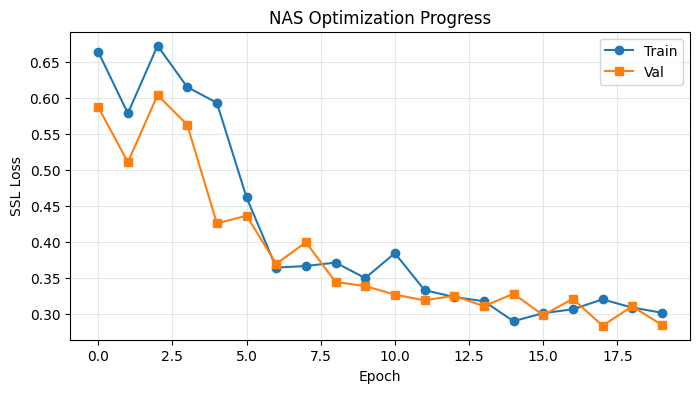


✓ Architecture search with pruning completed successfully!

[2/4] Creating and Analyzing Evaluation Model...
Discovered architecture for evaluation:
  cell_0_normal: ['ds_conv', 'irb_e3', 'se', 'irb_e3']
  cell_1_reduction: ['identity', 'irb_e3', 'ds_conv', 'irb_e6']
  cell_2_normal: ['irb_e6_se', 'irb_e3_se', 'se', 'se']
Building evaluation model with 3 cells
Initial channels: 8
Cell 0 (normal): input=8 -> output=8
    After concatenation: 8 -> 16 channels
Cell 1 (reduction): input=16 -> output=8
    After concatenation: 8 -> 16 channels
Cell 2 (normal): input=16 -> output=16
    After concatenation: 16 -> 32 channels
Final channels: 32

✅ Testing forward pass...
   Input shape: torch.Size([2, 3, 32, 32])
   Output shape: torch.Size([2, 10])

📊 AutoSSL-Tiny Model Analysis:


cells.1.edge_ops.0


📊 Model Statistics:
   Parameters: 0.01M (11,818 total)
   Total FLOPs: 11.31M (11,314,016 total)

   Operations breakdown (top 5):
     : 11.31M FLOPs
     cells: 11.04M FLOPs
     cells.2: 6.77M FLOPs
     cells.2.edge_ops: 6.77M FLOPs
     cells.2.edge_ops.0: 4.47M FLOPs

📏 CONSTRAINT CHECK:
   Parameters: 0.01M / 1.0M - ✅
   FLOPs: 11.31M / 100M - ✅
   🎉 ALL CONSTRAINTS MET!
   Parameters: 11,818 (0.01M)
   FLOPs: 11.31M

📏 AutoSSL-Tiny Constraint Verification:
   Parameters < 1M: ✅ (0.01M)
   FLOPs < 100M: ✅ (11.31M)
   🎉 AutoSSL-Tiny MEETS ALL CONSTRAINTS!

[3/4] Creating Comparison Models...



📊 MobileNetV2 (0.35x) Statistics:
   Parameters: 0.01M
   FLOPs: 1.42M
   Memory: 0.0MB

📊 MobileNetV3-Small Statistics:
   Parameters: 0.03M
   FLOPs: 7.55M
   Memory: 0.1MB

📊 EfficientNet-B0 (Tiny) Statistics:
   Parameters: 0.05M
   FLOPs: 8.00M
   Memory: 0.2MB

[4/4] Running Comprehensive Evaluation...

Evaluating AutoSSL-Tiny
Discovered architecture for evaluation:
  cell_0_normal: ['ds_conv', 'irb_e3', 'se', 'irb_e3']
  cell_1_reduction: ['identity', 'irb_e3', 'ds_conv', 'irb_e6']
  cell_2_normal: ['irb_e6_se', 'irb_e3_se', 'se', 'se']
Building evaluation model with 3 cells
Initial channels: 8
Cell 0 (normal): input=8 -> output=8
    After concatenation: 8 -> 16 channels
Cell 1 (reduction): input=16 -> output=8
    After concatenation: 8 -> 16 channels
Cell 2 (normal): input=16 -> output=16
    After concatenation: 16 -> 32 channels
Final channels: 32
📊 Parameters: 11,818 (0.01M)
📊 FLOPs: 11.31M

🔍 Testing on 1.0% data...
Discovered architecture for evaluation:
  cell_0_normal

📊 Parameters: 6,312 (0.01M)
📊 FLOPs: 1.42M

🔍 Testing on 1.0% data...

Training MobileNetV2 (0.35x) on 1.0% data...
Epoch  1/20: Loss=2.3008, Acc=10.00%, Best=10.00%
Epoch 11/20: Loss=1.6683, Acc=24.02%, Best=25.22%
Epoch 20/20: Loss=1.5266, Acc=30.56%, Best=30.56%
   Accuracy: 30.56%

🔍 Testing on 5.0% data...

Training MobileNetV2 (0.35x) on 5.0% data...
Epoch  1/20: Loss=2.1351, Acc=9.31%, Best=9.31%
Epoch 11/20: Loss=1.5640, Acc=38.31%, Best=38.31%
Epoch 20/20: Loss=1.3908, Acc=45.63%, Best=45.66%
   Accuracy: 45.66%

🔍 Testing on 10.0% data...

Training MobileNetV2 (0.35x) on 10.0% data...
Epoch  1/20: Loss=2.1085, Acc=20.89%, Best=20.89%
Epoch 11/20: Loss=1.6695, Acc=41.14%, Best=41.14%
Epoch 20/20: Loss=1.4953, Acc=51.71%, Best=51.87%
   Accuracy: 51.87%

🔍 Testing on 20.0% data...

Training MobileNetV2 (0.35x) on 20.0% data...
Epoch  1/20: Loss=1.9998, Acc=30.49%, Best=30.49%
Epoch 11/20: Loss=1.4515, Acc=51.93%, Best=51.93%


Epoch 20/20: Loss=1.3388, Acc=60.60%, Best=60.60%
   Accuracy: 60.60%

✅ Completed evaluation of MobileNetV2 (0.35x)

Evaluating MobileNetV3-Small
📊 Parameters: 27,058 (0.03M)
📊 FLOPs: 7.55M

🔍 Testing on 1.0% data...

Training MobileNetV3-Small on 1.0% data...
Epoch  1/20: Loss=2.2893, Acc=10.00%, Best=10.00%
Epoch 11/20: Loss=1.6543, Acc=24.63%, Best=24.63%
Epoch 20/20: Loss=1.4051, Acc=33.66%, Best=33.66%
   Accuracy: 33.66%

🔍 Testing on 5.0% data...

Training MobileNetV3-Small on 5.0% data...
Epoch  1/20: Loss=2.1241, Acc=10.00%, Best=10.00%
Epoch 11/20: Loss=1.5209, Acc=35.16%, Best=37.03%
Epoch 20/20: Loss=1.2845, Acc=43.98%, Best=43.98%
   Accuracy: 43.98%

🔍 Testing on 10.0% data...

Training MobileNetV3-Small on 10.0% data...
Epoch  1/20: Loss=2.0471, Acc=20.20%, Best=20.20%
Epoch 11/20: Loss=1.5576, Acc=44.58%, Best=45.03%
Epoch 20/20: Loss=1.4597, Acc=53.33%, Best=53.33%
   Accuracy: 53.33%

🔍 Testing on 20.0% data...

Training MobileNetV3-Small on 20.0% data...
Epoch  1/20

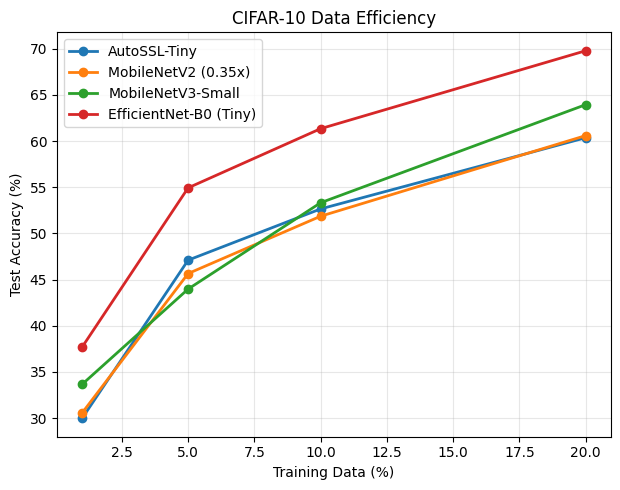


COMPREHENSIVE RESULTS SUMMARY

CIFAR-10 Data Efficiency (% Accuracy):
Model                    1%      5%      10%     20%     Params(M) FLOPs(M)
--------------------------------------------------------------------------------
AutoSSL-Tiny             30.0    47.1    52.7    60.4    0.0111.31
MobileNetV2 (0.35x)      30.6    45.7    51.9    60.6    0.011.42
MobileNetV3-Small        33.7    44.0    53.3    64.0    0.037.55
EfficientNet-B0 (Tiny)   37.7    54.9    61.4    69.8    0.058.00

FINAL CONSTRAINT CHECK
🎉 AutoSSL-Tiny MEETS ALL CONSTRAINTS: <1M params, <100M FLOPs
   Parameters: 0.01M (<1.0M)
   FLOPs: 11.31M (<100M)

📊 Comparison with Baselines:
   MobileNetV2 (0.35x): ✅ (Params: 0.01M, FLOPs: 1.42M)
   MobileNetV3-Small: ✅ (Params: 0.03M, FLOPs: 7.55M)
   EfficientNet-B0 (Tiny): ✅ (Params: 0.05M, FLOPs: 8.00M)

EVALUATION COMPLETED SUCCESSFULLY!

✅ Evaluation completed successfully!
AutoSSL-Tiny constraints met: Yes


In [5]:
def create_autossl_eval_model(ssl_model, num_classes=10):
    discovered_arch = ssl_model.discretize_architecture()

    print("Discovered architecture for evaluation:")
    for cell_name, ops in discovered_arch.items():
        print(f"  {cell_name}: {ops}")

    class AutoSSLNetEval(nn.Module):
        def __init__(self, ssl_model, discovered_arch, num_classes=10):
            super().__init__()

            self.stem = ssl_model.stem

            # Build cells EXACTLY as discovered - using THE SAME CELL CLASS AS SEARCH
            self.cells = nn.ModuleList()
            current_channels = ssl_model.C

            print(f"Building evaluation model with {len(discovered_arch)} cells")
            print(f"Initial channels: {current_channels}")

            for i, (cell_name, ops) in enumerate(discovered_arch.items()):
                is_reduction = 'reduction' in cell_name

                if is_reduction:
                    cell_C_out = min(current_channels * 1, 8)  # Same as search
                else:
                    cell_C_out = current_channels

                print(f"Cell {i} ({'reduction' if is_reduction else 'normal'}): input={current_channels} -> output={cell_C_out}")

                discrete_ops = []
                for edge_ops in ops:  # For each edge, use only the top operation
                    discrete_ops.append(edge_ops)  # Store the operation names

                cell = DiscreteCell(current_channels, cell_C_out, discrete_ops, reduction=is_reduction)
                self.cells.append(cell)

                current_channels = cell_C_out * 2
                print(f"    After concatenation: {cell_C_out} -> {current_channels} channels")

            self.classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(current_channels, num_classes)
            )

            print(f"Final channels: {current_channels}")

        def forward(self, x):
            x = self.stem(x)
            for cell in self.cells:
                x = cell(x)
            x = self.classifier(x)
            return x

    return AutoSSLNetEval(ssl_model, discovered_arch, num_classes)


class DiscreteCell(nn.Module):
    """Discrete version of Cell that uses specific operations instead of mixed ops"""
    def __init__(self, C_prev, C, op_names, reduction=False):
        super().__init__()
        self.C_in = C_prev
        self.C_out = C
        self.reduction = reduction

        self.preprocess0 = nn.Sequential(
            nn.Conv2d(C_prev, C, 1, bias=False),
            nn.BatchNorm2d(C)
        ) if C_prev != C else nn.Identity()

        self.preprocess1 = nn.Sequential(
            nn.Conv2d(C_prev, C, 1, bias=False),
            nn.BatchNorm2d(C)
        ) if C_prev != C else nn.Identity()

        self.edge_ops = nn.ModuleList()
        for op_name in op_names[:4]:  # Use first 4 operations (one per edge)
            op_fn = TINY_OPS[op_name]
            self.edge_ops.append(op_fn(C, C))  # Each op works with C channels

    def forward(self, s0):
        """Forward through cell with discrete operations"""
        s0_0 = self.preprocess0(s0)
        s0_1 = self.preprocess1(s0)

        states = [s0_0, s0_1]
        new_states = []

        node0_input = self.edge_ops[0](states[0]) + self.edge_ops[1](states[1])
        new_states.append(F.relu(node0_input))

        node1_input = self.edge_ops[2](states[0]) + self.edge_ops[3](states[1])
        new_states.append(F.relu(node1_input))

        # Output is concatenation of intermediate nodes (this doubles channels)
        return torch.cat(new_states, dim=1)


# ===============================================================
# BASELINE ARCHITECTURES
# ===============================================================
class TinyMobileNetV2(nn.Module):
    """MobileNetV2 with reduced width multiplier"""
    def __init__(self, num_classes=10, width_mult=0.35):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, int(32 * width_mult), 3, 1, 1, bias=False),
            nn.BatchNorm2d(int(32 * width_mult)),
            nn.ReLU6(inplace=True),

            self._make_layer(int(32 * width_mult), int(16 * width_mult), 1, 1),
            self._make_layer(int(16 * width_mult), int(24 * width_mult), 2, 6),
            self._make_layer(int(24 * width_mult), int(32 * width_mult), 2, 6),
            self._make_layer(int(32 * width_mult), int(64 * width_mult), 1, 6),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(int(64 * width_mult), num_classes)
        )

    def _make_layer(self, in_channels, out_channels, stride, expansion):
        layers = []
        expanded_channels = in_channels * expansion
        layers.extend([
            nn.Conv2d(in_channels, expanded_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(expanded_channels),
            nn.ReLU6(inplace=True),

            # Depthwise conv
            nn.Conv2d(expanded_channels, expanded_channels, 3, stride, 1,
                     groups=expanded_channels, bias=False),
            nn.BatchNorm2d(expanded_channels),
            nn.ReLU6(inplace=True),

            # Pointwise conv
            nn.Conv2d(expanded_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class TinyMobileNetV3(nn.Module):
    """MobileNetV3-Small with batch size fix - FIXED VERSION"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            self._bottleneck(16, 16, 3, 1, False),
            self._bottleneck(16, 24, 3, 2, False),
            self._bottleneck(24, 24, 3, 1, False),
            self._bottleneck(24, 32, 5, 2, True),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes)
        )

    def _bottleneck(self, in_channels, out_channels, kernel_size, stride, use_se):
        layers = []
        expanded = in_channels * 4
        layers.extend([
            nn.Conv2d(in_channels, expanded, 1, bias=False),
            nn.BatchNorm2d(expanded),
            nn.ReLU(inplace=True),

            nn.Conv2d(expanded, expanded, kernel_size, stride, kernel_size//2,
                     groups=expanded, bias=False),
            nn.BatchNorm2d(expanded),
            nn.ReLU(inplace=True),
        ])

        if use_se:
            layers.extend([
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(expanded, expanded//4, 1),
                nn.ReLU(inplace=True),
                nn.Conv2d(expanded//4, expanded, 1),
                nn.Sigmoid()
            ])

        layers.extend([
            nn.Conv2d(expanded, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

class TinyEfficientNetB0(nn.Module):
    """EfficientNet-B0 with reduced dimensions"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            self._mb_conv(32, 16, 1, 1),
            self._mb_conv(16, 24, 6, 2),
            self._mb_conv(24, 40, 6, 2),
            self._mb_conv(40, 80, 6, 1),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(80, num_classes)
        )

    def _mb_conv(self, in_channels, out_channels, expansion, stride):
        layers = []
        expanded = in_channels * expansion

        if expansion > 1:
            layers.extend([
                nn.Conv2d(in_channels, expanded, 1, bias=False),
                nn.BatchNorm2d(expanded),
                nn.ReLU(inplace=True),
            ])

        layers.extend([
            nn.Conv2d(expanded, expanded, 3, stride, 1, groups=expanded, bias=False),
            nn.BatchNorm2d(expanded),
            nn.ReLU(inplace=True),
            nn.Conv2d(expanded, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ==========================================
# COMPREHENSIVE EVALUATOR
# ==========================================
class PaperModelEvaluator:
    def __init__(self, data_fractions=[0.01, 0.05, 0.1, 0.2], epochs=20):
        self.data_fractions = data_fractions
        self.epochs = epochs
        self.results = {}

    def get_data_loaders(self, dataset_name='cifar10', data_fraction=1.0, batch_size=128):
        if dataset_name == 'cifar10':
            mean, std = [0.491, 0.482, 0.447], [0.202, 0.199, 0.201]
            num_classes = 10
        elif dataset_name == 'cifar100':
            mean, std = [0.507, 0.487, 0.441], [0.267, 0.256, 0.276]
            num_classes = 100
        else:
            raise ValueError(f"Unsupported dataset: {dataset_name}")

        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        trainset = getattr(torchvision.datasets, dataset_name.upper())(
            root='./data', train=True, download=True, transform=transform
        )
        testset = getattr(torchvision.datasets, dataset_name.upper())(
            root='./data', train=False, download=True, transform=test_transform
        )

        if data_fraction < 1.0:
            n_samples = int(len(trainset) * data_fraction)
            indices = torch.randperm(len(trainset))[:n_samples].tolist()
            trainset = torch.utils.data.Subset(trainset, indices)

        train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=batch_size, shuffle=True, num_workers=0
        )
        test_loader = torch.utils.data.DataLoader(
            testset, batch_size=batch_size, shuffle=False, num_workers=0
        )

        return train_loader, test_loader, len(trainset), num_classes


    def get_cifar100_extreme_low_data(self, n_samples_list=[200, 500, 1000], batch_size=128):
    # def get_cifar100_extreme_low_data(self, n_samples_list=[100, 200, 500], batch_size=128):
        mean, std = [0.507, 0.487, 0.441], [0.267, 0.256, 0.276]

        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

        results = {}
        for n_samples in n_samples_list:
            indices = torch.randperm(len(trainset))[:n_samples].tolist()
            subset = torch.utils.data.Subset(trainset, indices)

            train_loader = torch.utils.data.DataLoader(
                subset, batch_size=batch_size, shuffle=True, num_workers=0
            )
            test_loader = torch.utils.data.DataLoader(
                testset, batch_size=batch_size, shuffle=False, num_workers=0
            )

            results[n_samples] = (train_loader, test_loader, n_samples)

        return results

    def count_parameters(self, model):
        return sum(p.numel() for p in model.parameters())

    def estimate_flops(self, model, input_size=(1, 3, 32, 32)):
      """Consistent FLOPs estimation using count_flops"""
      flops, _ = count_flops(model, input_size, verbose=False, count_arch_params=False)
      return flops

    def train_model(self, model, train_loader, test_loader, model_name, data_fraction, use_mixup=True, epochs=None):
        if epochs is None:
            epochs = self.epochs

        print(f"\nTraining {model_name} on {data_fraction*100 if data_fraction < 1.0 else '100'}% data...")

        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
        criterion = nn.CrossEntropyLoss()

        def mixup_data(x, y, alpha=0.2):
            if alpha > 0:
                lam = np.random.beta(alpha, alpha)
            else:
                lam = 1
            batch_size = x.size(0)
            index = torch.randperm(batch_size).to(device)
            mixed_x = lam * x + (1 - lam) * x[index]
            y_a, y_b = y, y[index]
            return mixed_x, y_a, y_b, lam

        def mixup_criterion(criterion, pred, y_a, y_b, lam):
            return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

        best_acc = 0
        train_losses = []
        test_accuracies = []

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()

                if use_mixup and data_fraction >= 0.1:
                    inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=0.2)
                    outputs = model(inputs)
                    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            scheduler.step()

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

            acc = 100. * correct / total
            best_acc = max(best_acc, acc)
            train_losses.append(total_loss / len(train_loader))
            test_accuracies.append(acc)

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f'Epoch {epoch+1:2d}/{epochs}: Loss={total_loss/len(train_loader):.4f}, '
                      f'Acc={acc:.2f}%, Best={best_acc:.2f}%')

        return best_acc, train_losses, test_accuracies

    def evaluate_cifar10_data_efficiency(self, ssl_model):
      """Standardized evaluation for all models"""
      print("\n" + "="*70)
      print("CIFAR-10 DATA EFFICIENCY EVALUATION")
      print("="*70)

      # Create models ONCE
      autossl_model = create_autossl_eval_model(ssl_model).to(device)

      models_to_evaluate = {
          'AutoSSL-Tiny': autossl_model,
          'MobileNetV2 (0.35x)': TinyMobileNetV2(width_mult=0.35),
          'MobileNetV3-Small': TinyMobileNetV3(),
          'EfficientNet-B0 (Tiny)': TinyEfficientNetB0(),
      }

      results = {}

      for model_name, model in models_to_evaluate.items():
          print(f"\n{'='*60}")
          print(f"Evaluating {model_name}")
          print(f"{'='*60}")

          # Get standardized stats
          model_stats = get_model_stats(model)

          # Check constraints
          constraint_check = check_model_constraints(model, verbose=True)

          model_results = {
              **model_stats,
              **constraint_check,
              'data_efficiency': {}
          }

          # Data efficiency evaluation
          for fraction in self.data_fractions:
              print(f"\n🔍 Testing on {fraction*100:.1f}% data...")

              train_loader, test_loader, n_samples, _ = self.get_data_loaders(
                  'cifar10', fraction, batch_size=128
              )

              # Create fresh training model
              if model_name == 'AutoSSL-Tiny':
                  train_model = create_autossl_eval_model(ssl_model).to(device)
              else:
                  train_model = type(model)().to(device) if not isinstance(model, type) else model().to(device)

              # Train
              best_acc, _, _ = self.train_model(
                  train_model, train_loader, test_loader,
                  model_name, fraction,
                  use_mixup=(fraction >= 0.1),
                  epochs=self.epochs
              )

              model_results['data_efficiency'][fraction] = {
                  'accuracy': best_acc,
                  'samples': n_samples
              }

              del train_model
              cleanup()

          results[model_name] = model_results

      return results

    def plot_comprehensive_results(self, cifar10_results):
        try:
            # Plot 1: CIFAR-10 Data Efficiency
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            for model_name, results in cifar10_results.items():
                fractions = []
                accuracies = []
                for fraction, metrics in results['data_efficiency'].items():
                    fractions.append(fraction * 100)
                    accuracies.append(metrics['accuracy'])
                plt.plot(fractions, accuracies, marker='o', label=model_name, linewidth=2)

            plt.xlabel('Training Data (%)')
            plt.ylabel('Test Accuracy (%)')
            plt.title('CIFAR-10 Data Efficiency')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Print comprehensive results table
            print("\n" + "="*80)
            print("COMPREHENSIVE RESULTS SUMMARY")
            print("="*80)

            # CIFAR-10 Summary
            print("\nCIFAR-10 Data Efficiency (% Accuracy):")
            print("Model".ljust(25) + "1%".ljust(8) + "5%".ljust(8) + "10%".ljust(8) + "20%".ljust(8) + "Params(M)".ljust(10) + "FLOPs(M)")
            print("-"*80)
            for model_name, results in cifar10_results.items():
                params_m = results['parameters'] / 1e6
                flops_m = results['flops'] / 1e6
                accuracies = [f"{results['data_efficiency'][f]['accuracy']:.1f}"
                            for f in self.data_fractions]
                print(f"{model_name.ljust(25)}{accuracies[0].ljust(8)}{accuracies[1].ljust(8)}{accuracies[2].ljust(8)}{accuracies[3].ljust(8)}{params_m:.2f}".ljust(10) + f"{flops_m:.2f}")

        except Exception as e:
            print(f"Plotting error: {e}")

# MAIN EVALUATION
def run_evaluation():
    print("AutoSSL-Tiny: Evaluation Framework")
    print("="*70)

    try:
        # ==============================================
        # STEP 1: Architecture Search
        # ==============================================
        print("\n[1/4] Running Architecture Search...")
        ssl_model, history, final_arch = main()  # Get SSL model from main()

        if ssl_model is None:
            print("⚠️  Architecture search failed - aborting evaluation.")
            return None, None, None

        # ==============================================
        # STEP 2: Create and Analyze Evaluation Model
        # ==============================================
        print("\n[2/4] Creating and Analyzing Evaluation Model...")

        # Create the evaluation model
        autossl_eval_model = create_autossl_eval_model(ssl_model)
        autossl_eval_model = autossl_eval_model.to(device)

        # Test forward pass
        print("\n✅ Testing forward pass...")
        test_input = torch.randn(2, 3, 32, 32).to(device)
        with torch.no_grad():
            output = autossl_eval_model(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")

        # Analyze AutoSSL model - DON'T count architecture parameters for eval model
        print("\n📊 AutoSSL-Tiny Model Analysis:")
        flops, weight_params = count_flops(autossl_eval_model, input_size=(1, 3, 32, 32),
                                          verbose=True, count_arch_params=False)

        print(f"   Parameters: {weight_params:,} ({weight_params/1e6:.2f}M)")
        print(f"   FLOPs: {flops/1e6:.2f}M")

        # Check constraints
        print("\n📏 AutoSSL-Tiny Constraint Verification:")
        meets_params = weight_params < 1e6
        meets_flops = flops < 100e6
        print(f"   Parameters < 1M: {'✅' if meets_params else '❌'} ({weight_params/1e6:.2f}M)")
        print(f"   FLOPs < 100M: {'✅' if meets_flops else '❌'} ({flops/1e6:.2f}M)")

        if meets_params and meets_flops:
            print("   🎉 AutoSSL-Tiny MEETS ALL CONSTRAINTS!")
        else:
            print("   ⚠️  AutoSSL-Tiny exceeds some constraints")

        autossl_stats = {
            'parameters': weight_params,
            'flops': flops,
            'meets_params': meets_params,
            'meets_flops': meets_flops
        }

        # ==============================================
        # STEP 3: Create All Models for Comparison
        # ==============================================
        print("\n[3/4] Creating Comparison Models...")

        # Create baseline models
        baseline_models = {
            'MobileNetV2 (0.35x)': TinyMobileNetV2(width_mult=0.35),
            'MobileNetV3-Small': TinyMobileNetV3(),
            'EfficientNet-B0 (Tiny)': TinyEfficientNetB0(),
        }

        # Convert all to device and get their stats
        baseline_stats = {}
        for name, model_class in baseline_models.items():
            model = model_class.to(device) if hasattr(model_class, 'to') else model_class().to(device)
            baseline_models[name] = model

            # Get stats
            stats = get_model_stats(model)
            baseline_stats[name] = stats

            print(f"\n📊 {name} Statistics:")
            print(f"   Parameters: {stats['parameters_m']:.2f}M")
            print(f"   FLOPs: {stats['flops_m']:.2f}M")
            print(f"   Memory: {stats['memory_mb']:.1f}MB")

        # ==============================================
        # STEP 4: Comprehensive Evaluation
        # ==============================================
        print("\n[4/4] Running Comprehensive Evaluation...")
        evaluator = PaperModelEvaluator(
            data_fractions=[0.01, 0.05, 0.1, 0.2],
            epochs=20
        )

        # Store results
        cifar10_results = {}

        # Create model factory functions to ensure fresh instances
        model_factories = {
            'AutoSSL-Tiny': lambda: create_autossl_eval_model(ssl_model).to(device),
            'MobileNetV2 (0.35x)': lambda: TinyMobileNetV2(width_mult=0.35).to(device),
            'MobileNetV3-Small': lambda: TinyMobileNetV3().to(device),
            'EfficientNet-B0 (Tiny)': lambda: TinyEfficientNetB0().to(device),
        }

        # Evaluate each model
        for model_name in model_factories.keys():
            print(f"\n{'='*60}")
            print(f"Evaluating {model_name}")
            print(f"{'='*60}")

            try:
                # Create a fresh instance for stats measurement
                temp_model = model_factories[model_name]()

                # Get model statistics
                if model_name == 'AutoSSL-Tiny':
                    params = weight_params
                    flops_val = flops
                else:
                    params = sum(p.numel() for p in temp_model.parameters())
                    flops_val, _ = count_flops(temp_model, verbose=False, count_arch_params=False)

                del temp_model
                cleanup()

                print(f"📊 Parameters: {params:,} ({params/1e6:.2f}M)")
                print(f"📊 FLOPs: {flops_val/1e6:.2f}M")

                model_results = {
                    'parameters': params,
                    'flops': flops_val,
                    'data_efficiency': {}
                }

                # Test on different data fractions
                for fraction in evaluator.data_fractions:
                    print(f"\n🔍 Testing on {fraction*100:.1f}% data...")

                    # Get data loaders for this fraction
                    train_loader, test_loader, n_samples, _ = evaluator.get_data_loaders(
                        'cifar10', fraction, batch_size=128
                    )

                    # Create a FRESH instance for training
                    train_model = model_factories[model_name]()

                    # Train and evaluate
                    best_acc, _, _ = evaluator.train_model(
                        train_model, train_loader, test_loader,
                        model_name, fraction,
                        use_mixup=(fraction >= 0.1),
                        epochs=evaluator.epochs
                    )

                    model_results['data_efficiency'][fraction] = {
                        'accuracy': best_acc,
                        'samples': n_samples
                    }

                    print(f"   Accuracy: {best_acc:.2f}%")

                    # Cleanup
                    del train_model
                    cleanup()

                cifar10_results[model_name] = model_results
                print(f"\n✅ Completed evaluation of {model_name}")

            except Exception as e:
                print(f"❌ Error evaluating {model_name}: {e}")
                import traceback
                traceback.print_exc()
                continue

        # ==============================================
        # STEP 5: Generate Final Results
        # ==============================================
        print("\n" + "="*70)
        print("GENERATING FINAL RESULTS")
        print("="*70)

        # Print summary table
        print("\n📋 SUMMARY TABLE - CIFAR-10 Data Efficiency:")
        print("="*80)
        print(f"{'Model':<25} {'Params(M)':<10} {'FLOPs(M)':<10} ", end="")
        for fraction in evaluator.data_fractions:
            print(f"{fraction*100:.0f}%".ljust(8), end="")
        print()
        print("-"*80)

        for model_name, results in cifar10_results.items():
            params_m = results['parameters'] / 1e6
            flops_m = results['flops'] / 1e6
            accuracies = [f"{results['data_efficiency'][f]['accuracy']:.1f}"
                         for f in evaluator.data_fractions]

            # Build row
            row = f"{model_name:<25} {params_m:<10.2f} {flops_m:<10.2f} "
            for acc in accuracies:
                row += f"{acc:<8}"

            # Add constraint markers
            if model_name == 'AutoSSL-Tiny':
                if autossl_stats['meets_params'] and autossl_stats['meets_flops']:
                    row += " ✅"
                else:
                    row += " ⚠️"

            print(row)

        print("-"*80)

        # Plot results
        print("\n📈 Generating plots...")
        try:
            evaluator.plot_comprehensive_results(cifar10_results)
        except Exception as e:
            print(f"   Plotting failed: {e}")

        # Final constraint check
        print("\n" + "="*70)
        print("FINAL CONSTRAINT CHECK")
        print("="*70)

        autossl_meets = autossl_stats['meets_params'] and autossl_stats['meets_flops']
        if autossl_meets:
            print("🎉 AutoSSL-Tiny MEETS ALL CONSTRAINTS: <1M params, <100M FLOPs")
            print(f"   Parameters: {autossl_stats['parameters']/1e6:.2f}M (<1.0M)")
            print(f"   FLOPs: {autossl_stats['flops']/1e6:.2f}M (<100M)")
        else:
            print("⚠️  AutoSSL-Tiny EXCEEDS CONSTRAINTS:")
            if not autossl_stats['meets_params']:
                print(f"   ❌ Parameters: {autossl_stats['parameters']/1e6:.2f}M (exceeds 1.0M)")
            if not autossl_stats['meets_flops']:
                print(f"   ❌ FLOPs: {autossl_stats['flops']/1e6:.2f}M (exceeds 100M)")

        # Compare with baselines
        print("\n📊 Comparison with Baselines:")
        for model_name, results in cifar10_results.items():
            if model_name != 'AutoSSL-Tiny':
                meets_params = results['parameters'] < 1e6
                meets_flops = results['flops'] < 100e6
                status = "✅" if meets_params and meets_flops else "⚠️"
                print(f"   {model_name}: {status} (Params: {results['parameters']/1e6:.2f}M, FLOPs: {results['flops']/1e6:.2f}M)")

        print("\n" + "="*70)
        print("EVALUATION COMPLETED SUCCESSFULLY!")
        print("="*70)

        return cifar10_results, final_arch, autossl_stats

    except Exception as e:
        print(f"\n❌ Evaluation error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

results = run_evaluation()
if results is not None:
    cifar10_results, final_arch, autossl_stats = results
    print(f"\n✅ Evaluation completed successfully!")
    print(f"AutoSSL-Tiny constraints met: {'Yes' if autossl_stats['meets_params'] and autossl_stats['meets_flops'] else 'No'}")
else:
    print("❌ Evaluation failed")